# Предсказание оттока клиентов

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Для проекта по анализу оттока клиентов из банка необходимо сделать прогноз, уйдет ли клиент в ближайшем будущем или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

## Подготовка данных

Установим необходимые пакеты, если они отсутствуют

In [70]:
def check_if_installed(packages):
    for package in packages:
        try:
            exec(f'import {package}')
        except Exception as ex:
            print(ex)
            !pip install {package}
            # exec(f'import {package}')

libs = [
    'scikit-learn==1.1.3',
    'imblearn'
]

check_if_installed(libs)


invalid syntax (<string>, line 1)


In [71]:
import os

from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим датасет и посмотрим на данные.

In [72]:
BASE_DIR = os.getcwd()

df = pd.read_csv(f'{BASE_DIR}/datasets/Churn_Modelling.csv')

In [73]:
df.head(5)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки:**  
  
`RowNumber` - индекс строки  
`CustomerId` - уникальный идентификатор клиента  
`Surname` - фамилия  
`CreditScore` - кредитный рейтинг  
`Geography` - страна проживания  
`Gender` - пол  
`Age` - возраст  
`Tenure` - сколько лет человек является клиентом банка  
`Balance` - баланс на счете  
`NumOfProducts` - количество банковских продуктов, используемых клиентом  
`HasCrCard` - наличие кредитной карты  
`IsActiveMember` - активность клиента  
`EstimatedSalary` - зарплата  
  
**Целевой признак:**  
  
`Exited` - факт ухода клиента 



Изучим общие характеристики датасета

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Пропуски в данных отсутствуют. В столбцах RowNumber, Surname, CustomerId нет необходимости, они излишни для обучения модели, удалим их.

In [75]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)


In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


На первый взгляд в данных не видны аномалии.

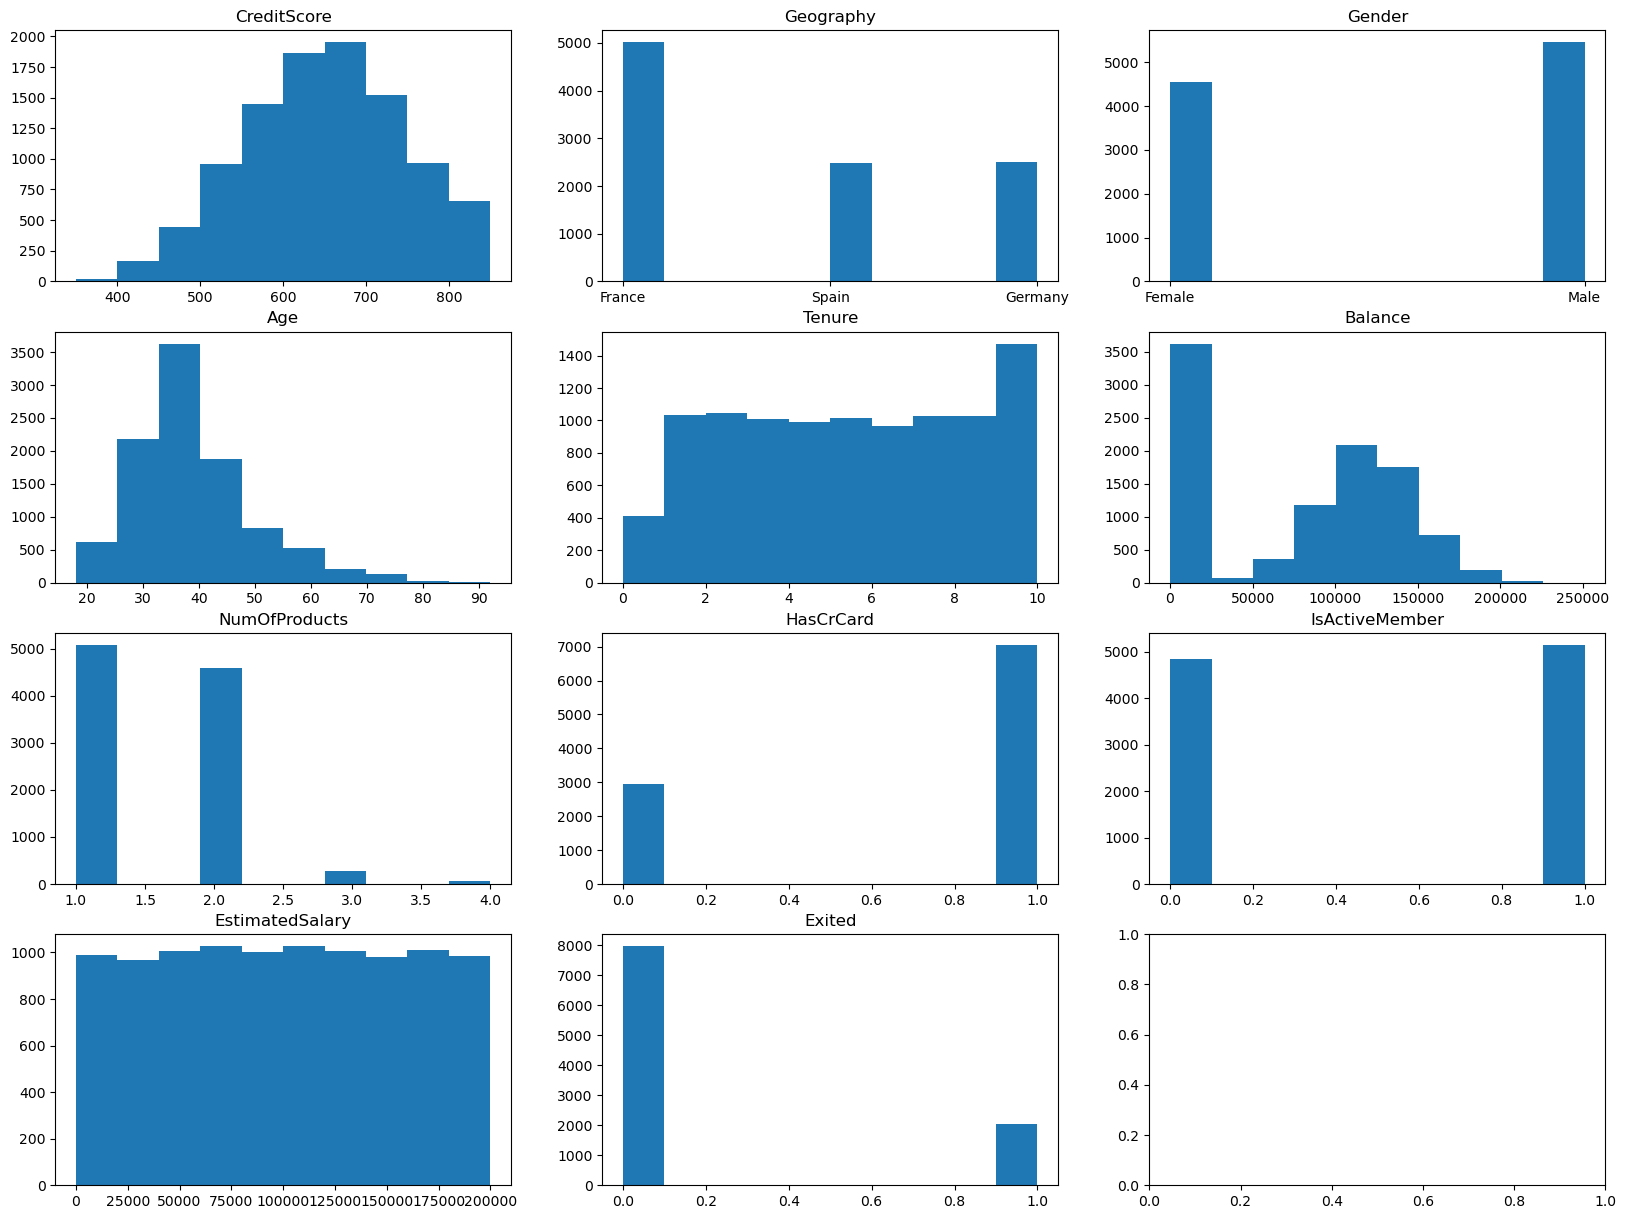

In [77]:
import math

fig, axs = plt.subplots(math.ceil(len(df.columns)/3), 3, figsize=(20, 15))
for i, col in enumerate(df.columns):
    axs[i//3][i%3].hist(df[col])
    axs[i//3][i%3].set_title(col)
plt.show()


На второй взгляд тоже.

Разделим выборку на обучающую, валидационную и тестовую в отношении 4:1:1

In [26]:
target = df['Exited']
features = df.drop(['Exited'], axis=1)
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.20, random_state=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=1)
features_test_cat = features_test.copy()


Проверим корректность разбивки.

In [27]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape


((6000, 10), (6000,), (2000, 10), (2000,), (2000, 10), (2000,))

`Gender`, `Geography` - категориальные признаки, изучим их подробнее и выберем метод обработки.

In [28]:
features_train['Gender'].value_counts()

Male      3281
Female    2719
Name: Gender, dtype: int64

In [29]:
features_train['Geography'].value_counts()

France     2976
Germany    1520
Spain      1504
Name: Geography, dtype: int64

В признаках `Gender` и `Geography` две и три категории соответственно. Категорий не много ,значит мы можем применить метод `OneHotEncoding`

In [30]:
cats = ['Gender', 'Geography']

In [31]:
encoder_ohe = OneHotEncoder(
    drop='first', handle_unknown='ignore', sparse=False
)

encoder_ohe.fit(features_train[cats])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [32]:
features_train[encoder_ohe.get_feature_names_out()]\
      = encoder_ohe.transform(features_train[cats])
features_train = features_train.drop(cats, axis=1)

In [33]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
4495,789,32,7,69423.52,1,1,0,107499.39,0.0,0.0,0.0
6470,583,41,5,77647.60,1,1,0,190429.52,0.0,1.0,0.0
2221,767,35,6,132253.22,1,1,0,115566.57,0.0,1.0,0.0
7686,718,48,9,0.00,2,1,1,72105.63,1.0,0.0,0.0
9419,686,26,1,57422.62,1,1,1,79189.40,1.0,1.0,0.0


Тем же энекодером закодируем валидационную и тестовую выборки

In [34]:
features_valid[encoder_ohe.get_feature_names_out()]\
    = encoder_ohe.transform(features_valid[cats])
features_valid = features_valid.drop(cats, axis=1)

features_test[encoder_ohe.get_feature_names_out()]\
    = encoder_ohe.transform(features_test[cats])
features_test = features_test.drop(cats, axis=1)

Проверим результат

In [35]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
7857,850,27,6,96654.72,2,0,0,152740.16,1.0,0.0,0.0
9924,632,50,5,107959.39,1,1,1,6985.34,0.0,1.0,0.0
3087,439,36,2,165536.28,2,1,1,123956.83,1.0,0.0,0.0
3513,790,33,10,135120.72,1,0,0,195204.99,0.0,0.0,0.0
2105,492,31,7,0.00,2,1,1,49463.44,0.0,0.0,0.0


In [53]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
9953,-1.050084,0.751753,-1.016183,-1.225276,0.830175,1,1,-0.049260,1.0,0.0,0.0
3850,0.296317,-0.479077,-0.673341,1.067533,-0.912060,1,0,-0.582541,1.0,0.0,0.0
4962,-1.246866,0.278357,-1.016183,-1.225276,0.830175,0,1,-0.163139,0.0,0.0,0.0
3886,0.607025,-0.479077,1.040868,1.140183,0.830175,0,1,-1.717256,1.0,1.0,0.0
5437,-1.122583,-0.857794,0.355184,-0.049517,-0.912060,1,1,1.341709,1.0,1.0,0.0


Стандартизируем значения числовых признаков:  
`CreditScore`  
`Age`  
`Balance`  
`Tenure`  
`EstimatedSalary`  
`NumOfProducts`

In [54]:
scaler = StandardScaler()
nums = [
    'CreditScore', 
    'Age', 
    'Balance',
    'Tenure', 
    'EstimatedSalary', 
    'NumOfProducts'
]

features_train[nums] = scaler.fit_transform(features_train[nums])
features_valid[nums] = scaler.fit_transform(features_valid[nums])
features_test[nums] = scaler.fit_transform(features_test[nums])

In [55]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
4495,1.427934,-0.656100,0.681651,-0.113714,-0.905397,1,0,0.134255,0.0,0.0,0.0
6470,-0.705851,0.198238,-0.014444,0.018224,-0.905397,1,0,1.572963,0.0,1.0,0.0
2221,1.200054,-0.371320,0.333604,0.894255,-0.905397,1,0,0.274208,0.0,1.0,0.0
7686,0.692503,0.862723,1.377746,-1.227467,0.805051,1,1,-0.479772,1.0,0.0,0.0
9419,0.361041,-1.225658,-1.406634,-0.306243,-0.905397,1,1,-0.356880,1.0,1.0,0.0


Там где возможно заменим типы данных на более лёгкие, используем метод downcast

In [56]:
feature_train = features_train.apply(pd.to_numeric, downcast='integer')
feature_train = feature_train.apply(pd.to_numeric, downcast='float')

feature_valid = features_valid.apply(pd.to_numeric, downcast='integer')
feature_valid = feature_valid.apply(pd.to_numeric, downcast='float')

features_test = features_test.apply(pd.to_numeric, downcast='integer')
features_test = features_test.apply(pd.to_numeric, downcast='float')

feature_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 4495 to 7029
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   float32
 1   Age                6000 non-null   float32
 2   Tenure             6000 non-null   float32
 3   Balance            6000 non-null   float32
 4   NumOfProducts      6000 non-null   float32
 5   HasCrCard          6000 non-null   int8   
 6   IsActiveMember     6000 non-null   int8   
 7   EstimatedSalary    6000 non-null   float32
 8   Gender_Male        6000 non-null   int8   
 9   Geography_Germany  6000 non-null   int8   
 10  Geography_Spain    6000 non-null   int8   
dtypes: float32(6), int8(5)
memory usage: 216.8 KB




**В результате подготовки данных:**
   - были удалены признаки с излишней информацией; 
   - данные разделены на выборки;  
   - к категориальным признакам примененён метод OHE;
   - количественные признакми стандартизированы;
   - типы данных заменены на более лёгкие.

Изучим баланс классов

In [57]:
weights = target_train.value_counts(normalize=True)
print(weights)


0    0.798833
1    0.201167
Name: Exited, dtype: float64


Классы целевого признака не сбалансированы, необходимо это исправить.  
Прежде чем бороться с дисбалансом найдём лучшие параметры модели на несбалансированной выборке, будем их использовать в качестве ориентира при оценке качества балансировки классов.  
Основная цель задачи предсказать отток клиентов, наиболее важная метрика для нас recall, оптимизируем по AUC-ROC.

## Обучение моделей

### Функция для оптимизации параметров классических моделей

In [38]:
def optimizer(X_t, y_t, X_v, y_v, max_depth, n_estimators, random_state, balance=None):
    """
    Функция обучает логистическую регрессию, решающее дерево, случайный лес и выводит их f1 и auc_roc.

    Аргументы:
    X_t - признаки обучающей выборки;
    y_t - целевой признак обучающей выборки;
    X_v - признаки валидационной выборки;
    y_v - целевой признак валидационной выборки;
    max_depth - максимальная глубина дерева (для DecisionTreeClassifier и RandomForestClassifier);
    n_estimators - количество деревьев (для RandomForestClassifier);
    random_state - параметр для воспроизводимости результатов;
    balance - параметр для балансировки классов (по умолчанию None).

    Результаты:
    best_model_rf - лучшая модель с максимальной метрикой f1.
    """
    best_f1_dt, best_auc_roc_dt, best_model_dt = 0, 0, None
    best_f1_rf, best_auc_roc_rf, best_model_rf = 0, 0, None

    model_cb = CatBoostClassifier(verbose=0, random_state=random_state)
    model_cb.fit(X_t, y_t)
    y_p = model_cb.predict(X_v)
    f1_cb = f1_score(y_v, y_p)
    auc_roc_cb = roc_auc_score(target_valid, model_cb.predict_proba(X_v)[:, 1])

    model_lr = LogisticRegression(
        random_state=random_state, solver='liblinear', class_weight=balance)
    model_lr.fit(X_t, y_t)
    y_p = model_lr.predict(X_v)
    f1_lr = f1_score(y_v, y_p)
    auc_roc_lr = roc_auc_score(target_valid, model_lr.predict_proba(X_v)[:, 1])

    for depth in range(1, max_depth, 1):
        model_dt = DecisionTreeClassifier(
            random_state=random_state, max_depth=depth, class_weight=balance)
        model_dt.fit(X_t, y_t)
        y_p = model_dt.predict(X_v)
        f1_dt = f1_score(y_v, y_p)
        if f1_dt > best_f1_dt:
            auc_roc_dt = roc_auc_score(
                target_valid, model_dt.predict_proba(X_v)[:, 1])
            best_f1_dt, best_model_dt, best_auc_roc_dt = f1_dt, model_dt, auc_roc_dt

        for n_est in range(1, n_estimators, 1):
            model_rf = RandomForestClassifier(
                random_state=random_state, n_estimators=n_est, max_depth=depth, class_weight=balance)
            model_rf.fit(X_t, y_t)
            y_p = model_rf.predict(X_v)
            f1_rf = f1_score(y_v, y_p)
            if f1_rf > best_f1_rf:
                auc_roc_rf = roc_auc_score(
                    target_valid, model_rf.predict_proba(X_v)[:, 1])
                best_f1_rf, best_model_rf, best_auc_roc_rf = f1_rf, model_rf, auc_roc_rf


    results = {
        'model_cb': {
            'best_f1': f1_cb,
            'best_auc_roc': auc_roc_cb,
            'model' : model_cb
        },
        'model_lr': {
            'best_f1': f1_lr,
            'best_auc_roc': auc_roc_lr,
            'model' : model_lr
        },
        'model_dt': {
            'best_f1': best_f1_dt,
            'best_auc_roc': best_auc_roc_dt,
            'model' : model_dt
        },
        'model_rf': {
            'best_f1': best_f1_rf,
            'best_auc_roc': best_auc_roc_rf,
            'model' : model_rf
        }
    }

    print(pd.DataFrame.from_dict(results, orient='index'))

    best_model = max(results, key=lambda x: results[x]['best_auc_roc'])

    return results[best_model]['model']



In [39]:
optimizer(feature_train, target_train, feature_valid, target_valid, 30, 50, 1)


           best_f1  best_auc_roc  \
model_cb  0.549849      0.846332   
model_lr  0.301075      0.763872   
model_dt  0.514200      0.798354   
model_rf  0.559398      0.821798   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(random_state=1, solver='lib...  
model_dt  DecisionTreeClassifier(max_depth=29, random_st...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Лучший показатель у модели CatBoostClassifier, худший у LogisticRegression  

## Борьба с дисбалансом

### Балансирование взвешиванием классов

In [40]:
model_weighted = optimizer(feature_train, target_train,
                           feature_valid, target_valid, 30, 50, 1, 'balanced')


           best_f1  best_auc_roc  \
model_cb  0.549849      0.846332   
model_lr  0.496991      0.763609   
model_dt  0.570297      0.778068   
model_rf  0.621908      0.839515   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Лучший результат у CatBoostClassifier, причём он не отличается от результата без взвешивания, попробуем также другие варианты балансировки.

### Балансирование методом downsample

Сбалансируем выборку.

In [41]:
rus = RandomUnderSampler(random_state=1)
feature_train_down, target_train_down = rus.fit_resample(
    feature_train, target_train)


In [42]:
print(target_train_down.value_counts(normalize=True))


0    0.5
1    0.5
Name: Exited, dtype: float64


Обучим модель на выборке

In [43]:
model_down = optimizer(feature_train_down, target_train_down,
                       feature_valid, target_valid, 30, 50, 1, 'balanced')


           best_f1  best_auc_roc  \
model_cb  0.577143      0.843515   
model_lr  0.497427      0.762480   
model_dt  0.563536      0.815538   
model_rf  0.590420      0.831662   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Метод балансировки downsample показал результат не лучше, чем взвешивание классов. Случайный лес также в лидерах и по f1 и по auc_roc

### Балансирование методом upsample

Сбалансируем выборку

In [44]:
oversample = SMOTE(random_state=1)
feature_train_up, target_train_up = oversample.fit_resample(
    feature_train, target_train)


Проверим баланс классов

In [45]:
print(target_train_up.value_counts(normalize=True))


0    0.5
1    0.5
Name: Exited, dtype: float64


Обучим модель на выборке

In [46]:
model_up = optimizer(feature_train_up, target_train_up,
                     feature_valid, target_valid, 30, 50, 1, 'balanced')


           best_f1  best_auc_roc  \
model_cb  0.393970      0.807306   
model_lr  0.485114      0.762788   
model_dt  0.500000      0.734887   
model_rf  0.601985      0.812132   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Метод балансировки upsample также не показал результат лучше, чем взвешивание классов.

**В результате подбора метода балансировки и оптимизации гиперпараметров можно сделать следующие выводы:**
- независимо от того сбалансирована ли выборка и независимо от метода балансировки, лучшей из рассмотренных моделей является `CatBoostClassifier`;
- модель лучше обучилась на несбалансированной выборке;

Результат на валидационной выборке:  
    f1 = 0.55  
    AUC-ROC = 0.85  

Оптимизируем гиперпараметры базовой модели с помощью GridSearchCV. Для кросс-валидации будем использовать выборку до разделения на обучающую и валидационную. Также мы можем пропустить шаг стандартизации числовых признаков и OHE, т.к. это не обязательно для CatBoost

In [47]:
model_cb = CatBoostClassifier(verbose=0, random_state=1, cat_features=cats)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8],
    'iterations': [50, 100, 200],
}

grid_search = GridSearchCV(
    model_cb, 
    param_grid, 
    cv=4, 
    n_jobs=-1, 
    scoring='roc_auc'
)

grid_search.fit(features_train_val, target_train_val)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 2, 'learning_rate': 0.05}
Best score:  0.869327653065124


Максимальный `AUC-ROC=0.87` достигнут при  
`max_depth` = 4  
`l2_leaf_reg` = 2  
`learning_rate` = 0.05  
`iterations` = 200  

## Тестирование модели

Протестируем лучшую из полученных моделей на тестовой выборке. 

In [48]:
model = grid_search.best_estimator_
target_predicted = model.predict(features_test_cat)
roc_auc = roc_auc_score(target_test, target_predicted)
print(f"ROC-AUC на тестовой выборке = {roc_auc}")


ROC-AUC на тестовой выборке = 0.7263958040363346


Модель показала удовлетворительный результат на тестовой выборке. Тест пройден.

Лучшая модель для решения задачи пронозирования ухода клиента - `CatBoostClassifier` с параметрами:
  `max_depth` = 4  
  `l2_leaf_reg` = 2  
  `learning_rate` = 0.05  
  `iterations` = 200  

Подберём порог для классификации и посмотрим какой recall мы можем получить.  
Взглянем на ROC-кривую.

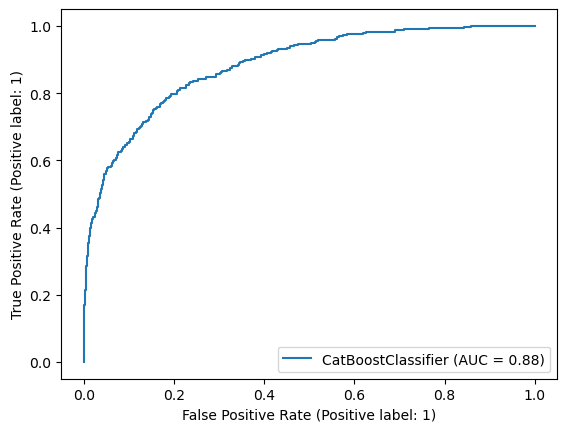

In [66]:
plot_roc_curve(model, features_test_cat, target_test)
plt.show()

Подберём оптимальное пороговое значение

In [68]:
target_predicted_probabilities = model.predict_proba(features_test_cat)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_predicted_probabilities)

# Находим индекс точки на графике, ближайшей к верхнему левому углу
index = np.argmax(np.abs(tpr - fpr))
# Определяем пороговое значение, соответствующее этой точке
threshold = thresholds[index]

print("Оптимальное пороговое значение:", threshold)

Оптимальное пороговое значение: 0.19067794856748335


Оценим recall при оптимальном пороговом значении

In [69]:
target_predicted = model.predict_proba(features_test_cat)[:, 1] > threshold
recall = recall_score(target_test, target_predicted, pos_label=1)
print(f"Recall на тестовой выборке = {recall:.2f}")

Recall на тестовой выборке = 0.80


**В процессе работы были проделаны следующие шаги:**
  - исходная выборка была подготовлена к работе;
  - модель была протестирована на несбалансированных данных;
  - модель была обучена на выборках сбаллансированных различными способами;
  - в ходе работы была использована функция подбирающая модели и гиперпараметры моделей;
  - лучшая модель была апробирована на тестовой выборке;
  - подобран threshold для максимизации recall.

Полученная модель будет успешно определять клиента банка прежде, чем он откажется от услуг в 80% случаев.